In [7]:
import pandas as pd
import glob as glob
import synapseclient
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import gridspec
from __future__ import division
%matplotlib inline

plt.rcParams["font.family"] = "arial"

tableau10 = [(78, 121, 167), (242, 142, 43), (225, 87, 89),
             (118, 183, 178), (89, 161, 79), (237, 201, 72),
             (176, 122, 161), (225, 157, 167), (156, 117, 95),
             (186, 176, 172)]
for i in range(len(tableau10)):    
    r, g, b = tableau10[i]    
    tableau10[i] = (r / 255., g / 255., b / 255.)    

# GENIE germline filtering
## Variants per sample
In this IPython notebook we will explore the number of variants per sample across GENIE as well as by institution, before and after applying our common variants filter. We also look at the number of somatic calls at potential germline sites(ExAC_AC_Adj > 1 and ExAC_FILTER=PASS), before and after applying our common variants filter, across GENIE and each individual center.
<br><br>
GENIE VCFs were annotated with VCF2MAF v1.6.12: <br>
source: https://github.com/mskcc/vcf2maf/blob/v1.6.12/docs/vep_maf_readme.txt

The following was generated on GENIE release 0.6: https://www.synapse.org/#!Synapse:syn7887009

## Results:
Our common variants filter shifts the distribution of variants per sample to the left. 128 samples had no variants which passed our common variants filter; at least one sample from each center fell into this category but weighted towards John-Hopkins and DFCI (51 and 47 samples, respectively). Filtering had the most effect on centers such as Vanderbilt (mean variants per sample 11.13 reduced to 9.2 after common variants filtering) and Dana-Farber (mean variants per sample 8.28 reduced to 7.70 after common variants filtering). 

We quantified the reduction in samples with somatic calls at potential germline sites (ExAC_AC_Adj > 1 and ExAC_FILTER=PASS), after implementing the “common_variant” filter. 7171 of the 17289 GENIE samples (41.5%) contained at least one such call, which reduced to 5454 samples (31.5%) after filtering. Strict germline filtering increased the number of GENIE samples with zero somatic calls at potential germline sites, from 10118 to 11835. Overall, the strict germline filtering pipeline decreased somatic calls at potential germline sites, from 13.3% to 8.7% of all variants in GENIE.

<a id='table.of.contents'></a>
## Table of Contents
1. <a href='#all.data'>Variants per Sample, GENIE</a>
2. <a href='#center.data'>Variants per Sample, by center</a>
4. <a href='#all.germline'>Number of Somatic Calls at Potential Germline Sites, GENIE</a>
5. <a href='#center.germline'>Number of Somatic Calls at Potential Germline Sites, by center</a>

In [2]:
#mkdir -p current_release; cd current_release/
#synapse get -r syn7887009

df = pd.read_csv('current_release/data_mutations_extended.txt', 
    sep = '\t', comment = '#', low_memory = False)

# Prep dataframe to handle allelic fraction
df['t_alt_count'] = pd.to_numeric(df['t_alt_count'], errors='coerce').fillna(0)
df['t_depth'] = pd.to_numeric(df['t_depth'], errors='coerce').fillna(0)
df['i_tumor_f'] = df['t_alt_count'].divide(df['t_depth'])
df['i_tumor_f'] = df['i_tumor_f'].fillna(0)

<a id='all.data'></a>
## 1. Number of Variants per Sample - GENIE
<a href='#table.of.contents'>Return to top</a><br>

We are interested in seeing the number of variants per sample across GENIE before and after applying our common variants filter. The change in variants per sample across the entire GENIE cohort is visualized and summary statistics are acquired.

<b>Results</b>: We find that our distribution of variants per sample is, as expected, shifted left after applying our common variants filter. Our filter reduces the mean variants per sample from 6.8 to 6.45 with large variance (14.44 and 14.24). The variance is likely due to some centers having matched normals (MSK and Princess Margaret) while the other cents had unmatched samples. This is investigated in the next section.

In [4]:
columns = ['sample', 'center', '# variants', '# common variants', '# uncommon variants']
variants_per_sample = pd.DataFrame([], columns = columns)
variants_per_sample.loc[:,'sample'] = df['Tumor_Sample_Barcode'].unique()
common_variant_classes = ['common_variant,common_variant', 'common_variant']

variants_per_sample.loc[:,['# variants', '# common variants', '# uncommon variants']] = [0]

for sample_ in df['Tumor_Sample_Barcode'].unique():
    index_ = variants_per_sample[variants_per_sample['sample'] == sample_].index.tolist()[0]
    df_sample_ = df[df['Tumor_Sample_Barcode'] == sample_]
    
    variants_per_sample.loc[index_,'sample'] = df_sample_['Tumor_Sample_Barcode'].tolist()[0]
    variants_per_sample.loc[index_,'center'] = df_sample_['Center'].tolist()[0]
    
    idx_common_variants = df_sample_['FILTER'].isin(common_variant_classes)
    variants_per_sample.loc[index_, '# variants'] = len(df_sample_)
    variants_per_sample.loc[index_, '# common variants'] = len(df_sample_[idx_common_variants])
    variants_per_sample.loc[index_, '# uncommon variants'] = len(df_sample_[~idx_common_variants])

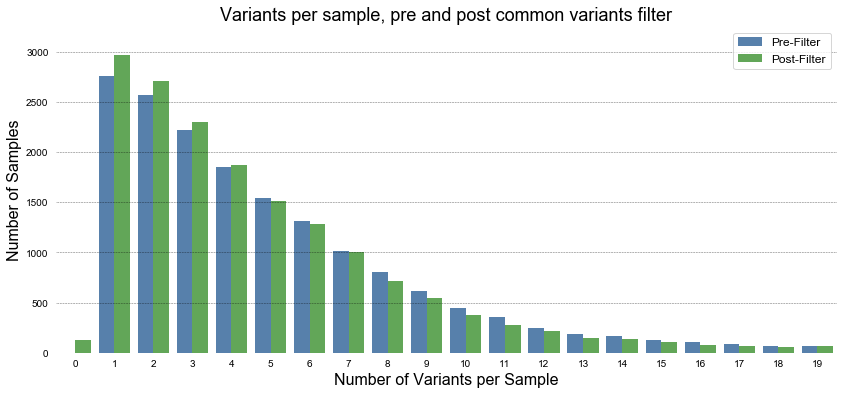

In [18]:
fig = plt.figure(figsize = (14,6))

ax = plt.subplot()
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False)
plt.tick_params(axis="both", which="both", bottom="off", top="off",
    labelbottom="on", left="off", right="off", labelleft="on")  

colors = [tableau10[0], tableau10[4]]
labels = ['Pre-Filter', 'Post-Filter']
data = [variants_per_sample['# variants'], variants_per_sample['# uncommon variants']]

plt.hist(data, bins = variants_per_sample['# variants'].max(), 
         color = colors, label = labels, alpha  = 0.95)

plt.xlim(0, 20)
plt.ylim(0, 3250)

ind = np.arange(20)
width = 0.40
ax.set_xticks(ind + 0.5)
ax.set_xticklabels(range(0,20))

ylow = 0
ymax = 9000
for y in range(ylow, ymax, 500):    
    plt.plot(range(-1, 20 + 1), [y] * (len(range(-1, 20)) + 1), "--", lw=0.5, color="black", alpha=0.6)

plt.legend(fontsize=12)

plt.ylabel('Number of Samples', fontsize = 16)
plt.xlabel('Number of Variants per Sample', fontsize = 16)
plt.title('Variants per sample, pre and post common variants filter', fontsize = 18)

plt.savefig('figures/6.1.variants_per_sample.pdf', bbox_inches = 'tight')
plt.show()

In [19]:
print 'For GENIE samples...Somatic Calls at Potential Germline Sites'
print '...mean number of variants:', variants_per_sample.loc[:,'# variants'].mean()
print '...median number of variants:', variants_per_sample.loc[:,'# variants'].median()
print '...std dev of variants:', variants_per_sample.loc[:,'# variants'].std()
print '...max number of variants:', variants_per_sample.loc[:, '# variants'].max()
print ''


print '...mean number of common variants:', variants_per_sample.loc[:,'# common variants'].mean()
print '...median number of common variants:', variants_per_sample.loc[:,'# common variants'].median()
print '...std dev of common variants:', variants_per_sample.loc[:,'# common variants'].std()
print '...max number of common variants:', variants_per_sample.loc[:, '# common variants'].max()
print ''

print '...mean number of remaining variants:', variants_per_sample.loc[:,'# uncommon variants'].mean()
print '...median number of remaining variants:', variants_per_sample.loc[:,'# uncommon variants'].median()
print '...std dev of remaining variants:', variants_per_sample.loc[:,'# uncommon variants'].std()
print '...max number of remaining variants:', variants_per_sample.loc[:, '# uncommon variants'].max()
print ''

For GENIE samples...Somatic Calls at Potential Germline Sites
...mean number of variants: 6.80295053515
...median number of variants: 4.0
...std dev of variants: 14.4480708506
...max number of variants: 443

...mean number of common variants: 0.354527046572
...median number of common variants: 0.0
...std dev of common variants: 0.868109236252
...max number of common variants: 16

...mean number of remaining variants: 6.44842348857
...median number of remaining variants: 4.0
...std dev of remaining variants: 14.2438252609
...max number of remaining variants: 437



<a id='center.data'></a>
## 2. Variants Per Sample, per center
<a href='#table.of.contents'>Return to top</a><br>

Summary statistics are gathered for the change in variants per sample on a per institution basis.

In [20]:
df['Center'].value_counts()

DFCI    50724
MSK     49532
VICC     9261
JHH      2965
UHN      2163
MDA      1261
NKI       856
GRCC      827
Name: Center, dtype: int64

In [24]:
centers = ['DFCI', 'GRCC', 'JHH', 'MDA', 'MSK', 'NKI', 'VICC', 'UHN']
vec = range(0, len(centers))

for i in vec:
    center_ = centers[i]
    print center_
    print ''
    
    df_center = df[df['Center'] == center_]
    vps_center = variants_per_sample[variants_per_sample['center'] == center_]
    
    print 'Reporting somatic calls at germline sites for center:', str(center_)
    
    total_mutations_pre = len(df_center)
    vps_pre = vps_center['# variants'].sum()
    pct_vps_pre = vps_pre / total_mutations_pre

    total_mutations_post = len(df_center[df_center['FILTER'] != 'common_variant'])
    vps_post = vps_center['# uncommon variants'].sum()
    pct_vps_post = vps_post / total_mutations_post

    print 'For GENIE samples...Variants Per Sample'
    print 'Total number of samples:', str(len(vps_center))
    print 'Total number of variants (Pre-Filter):', str(vps_center['# variants'].sum())
    print 'Total number of variants (Post-Filter):', str(vps_center['# uncommon variants'].sum())
    print ''
    
    print '...mean number of variants per sample:', vps_center.loc[:,'# variants'].mean()
    print '...median number of variants per sample:', vps_center.loc[:,'# variants'].median()
    print '...std dev of variants per sample:', vps_center.loc[:,'# variants'].std()
    print '...max number of variants per sample:', vps_center.loc[:, '# variants'].max()
    print ''

    print '...mean number of common variants per sample:', vps_center.loc[:,'# common variants'].mean()
    print '...median number of common variants per sample:', vps_center.loc[:,'# common variants'].median()
    print '...std dev of common variants per sample:', vps_center.loc[:,'# common variants'].std()
    print '...max number of common variants per sample:', vps_center.loc[:, '# common variants'].max()
    print ''

    print '...mean number of remaining variants per sample:', vps_center.loc[:,'# uncommon variants'].mean()
    print '...median number of remaining variants per sample:', vps_center.loc[:,'# uncommon variants'].median()
    print '...std dev of remaining variants per sample:', vps_center.loc[:,'# uncommon variants'].std()
    print '...max number of remaining variants per sample:', vps_center.loc[:, '# uncommon variants'].max()
    print ''
    
    print ''
    print ''
    print '----------------'

DFCI

Reporting somatic calls at germline sites for center: DFCI
For GENIE samples...Variants Per Sample
Total number of samples: 6167
Total number of variants (Pre-Filter): 50724
Total number of variants (Post-Filter): 47498

...mean number of variants per sample: 8.22506891519
...median number of variants per sample: 6.0
...std dev of variants per sample: 14.4313647565
...max number of variants per sample: 409

...mean number of common variants per sample: 0.523106859089
...median number of common variants per sample: 0.0
...std dev of common variants per sample: 0.939842954889
...max number of common variants per sample: 9

...mean number of remaining variants per sample: 7.70196205611
...median number of remaining variants per sample: 5.0
...std dev of remaining variants per sample: 14.2886024265
...max number of remaining variants per sample: 405



----------------
GRCC

Reporting somatic calls at germline sites for center: GRCC
For GENIE samples...Variants Per Sample
Total numbe

<a id='all.germline'></a>
## 3. Number of Somatic Calls at Potential Germline Sites
<a href='#table.of.contents'>Return to top</a><br>

We are interested in seeing how the number of somatic calls at potential germline sites changes before and after applying our common variants filter. This is not only useful for quantifying reidentification risk but also improves the confidence that our dataset is truly a somatic dataset. 

To identify which of our somatic sites are present at potential germline sites, we are defining a potential germline site as a genomic position that meets the following conditions based on ExAC - 
1. The annotation ExAC_AC_AN_Adj > 1 
2. ExAC_FILTER == 'PASS'

The rationale for this choice is that the variant must be present in ExAC and also be defined as likely germline by their own internal filter. 

<b>Results</b>: The figure above quantifies the reduction in samples with somatic calls at potential germline sites (ExAC_AC_AN_Adj > 1 and ExAC_FILTER=PASS), after implementing the “common_variant” filter. 7171 of the 17285 GENIE samples (41.5%) contained at least one such call, which reduced to 5454 samples (31.6%) after filtering. Overall, the strict germline filtering pipeline decreased somatic calls at potential germline sites, from 13.3% to 8.75% of all variants in GENIE.

In [25]:
df = pd.read_csv('current_release/data_mutations_extended.txt',
    sep = '\t', comment = '#', low_memory = False)

# Prep dataframe to handle allelic fraction
df['t_alt_count'] = pd.to_numeric(df['t_alt_count'], errors='coerce').fillna(0)
df['t_depth'] = pd.to_numeric(df['t_depth'], errors='coerce').fillna(0)
df['i_tumor_f'] = df['t_alt_count'].divide(df['t_depth'])
df['i_tumor_f'] = df['i_tumor_f'].fillna(0)

In [26]:
df['ExAC_Alleles'] = pd.DataFrame(df['ExAC_AC_AN_Adj'].fillna('0/1').str.split('/').tolist(), columns = ['A', 'B'])['A'].tolist()
idx_germ = (df['ExAC_Alleles'].astype(int) > 1) & (df['ExAC_FILTER'] == 'PASS')
df_germ = df[idx_germ]

pgv_per_sample = pd.DataFrame([], columns = ['sample', 'center', '# variants', '# common variants', '# uncommon variants'])
pgv_per_sample.loc[:,'sample'] = df['Tumor_Sample_Barcode'].unique()
common_variant_classes = ['common_variant,common_variant', 'common_variant']

pgv_per_sample.loc[:,['# variants', '# common variants', '# uncommon variants']] = [0]

for sample_ in df_germ['Tumor_Sample_Barcode'].unique():
    index_ = pgv_per_sample[pgv_per_sample['sample'] == sample_].index.tolist()[0]
    df_sample_ = df_germ[df_germ['Tumor_Sample_Barcode'] == sample_]
    
    pgv_per_sample.loc[index_,'sample'] = df_sample_['Tumor_Sample_Barcode'].tolist()[0]
    pgv_per_sample.loc[index_,'center'] = df_sample_['Center'].tolist()[0]
    
    pgv_per_sample.loc[index_, '# variants'] = len(df_sample_)
    idx_common_variants = df_sample_['FILTER'].isin(common_variant_classes)
    pgv_per_sample.loc[index_, '# common variants'] = len(df_sample_[idx_common_variants])
    pgv_per_sample.loc[index_, '# uncommon variants'] = len(df_sample_[~idx_common_variants])

In [27]:
pgv_per_sample['# variants'].value_counts().head(10)

0    10114
1     3576
2     1692
3      885
4      462
5      209
6      108
7       78
8       54
9       26
Name: # variants, dtype: int64

In [28]:
pgv_per_sample['# uncommon variants'].value_counts().head(10)

0    11831
1     3307
2     1260
3      533
4      163
5       65
6       36
7       20
8       18
9       12
Name: # uncommon variants, dtype: int64

In [29]:
variants_per_sample.head()

,sample,center,# variants,# common variants,# uncommon variants
0,GENIE-VICC-101416-unk-1,VICC,11,3,8
1,GENIE-VICC-102225-unk-1,VICC,17,3,14
2,GENIE-VICC-102424-unk-1,VICC,11,2,9
3,GENIE-VICC-102966-unk-1,VICC,5,2,3
4,GENIE-VICC-103244-unk-1,VICC,6,0,6


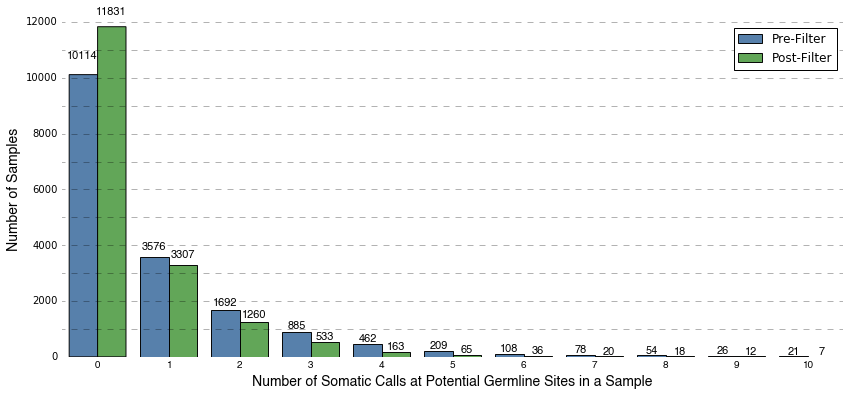

In [83]:
fig = plt.figure(figsize = (14,6))

ax = plt.subplot()
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False)
plt.tick_params(axis="both", which="both", bottom="off", top="off",
    labelbottom="on", left="off", right="off", labelleft="on")  

colors = [tableau10[0], tableau10[4]]
labels = ['Pre-Filter', 'Post-Filter']
data = [pgv_per_sample['# variants'], pgv_per_sample['# uncommon variants']]

histogram1 = plt.hist(data, bins = 51, color = colors, label = labels, alpha  = 0.95, width = 0.40)

plt.xlim(0, 11)
plt.ylim(0, 12000)

ind = np.arange(11)
width = 0.40
ax.set_xticks(ind + 0.5)
ax.set_xticklabels([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], **hfont)

ylow = 0
ymax = 13000
for y in range(ylow, ymax, 1000):    
    plt.plot(range(-1, 12 + 1), [y] * (len(range(-1, 12)) + 1), "--", lw=0.5, color="black", alpha=0.6)

plt.legend()

plt.ylabel('Number of Samples', fontsize = 14, **hfont)
plt.xlabel('Number of Somatic Calls at Potential Germline Sites in a Sample', fontsize = 14, **hfont)

vec = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
def histlabel(vec):
    for vec_ in vec:
        pre_value = pgv_per_sample['# variants'].value_counts()[vec_ - 1]
        post_value = pgv_per_sample['# uncommon variants'].value_counts()[vec_ - 1]
        
        ax.text(vec_ - 0.7, 1.05*pre_value, pre_value, 
                ha = 'center', va = 'bottom', fontsize = 11, **hfont)
        ax.text(vec_ - 0.3, 1.05*post_value, post_value, 
                ha = 'center', va = 'bottom', fontsize = 11, **hfont)

histlabel(vec)

pre_value = pgv_per_sample['# variants'].value_counts()[0]
post_value = pgv_per_sample['# uncommon variants'].value_counts()[0]
        
ax.text(1 - 0.72, 1.05*pre_value, pre_value, 
        ha = 'center', va = 'bottom', fontsize = 11, **hfont)
ax.text(1 - 0.31, 1.03*post_value, post_value, 
        ha = 'center', va = 'bottom', fontsize = 11, **hfont)

plt.savefig('figures/6.3.Somatic_Germline_per_sample.pdf', bbox_inches = 'tight')
plt.show()

In [84]:
pgv_per_sample['# variants'].value_counts().head(20)

0     10114
1      3576
2      1692
3       885
4       462
5       209
6       108
7        78
8        54
9        26
10       21
12       11
13        8
14        7
11        7
16        5
20        4
51        2
36        2
15        2
Name: # variants, dtype: int64

In [85]:
pgv_per_sample['# uncommon variants'].value_counts().head(20)

0     11831
1      3307
2      1260
3       533
4       163
5        65
6        36
7        20
8        18
9        12
10        7
14        4
12        3
11        3
13        3
39        3
15        2
16        2
18        2
24        2
Name: # uncommon variants, dtype: int64

In [30]:
print 'For GENIE samples...Somatic Calls at Potential Germline Sites'
print '...mean number of variants:', pgv_per_sample.loc[:,'# variants'].mean()
print '...median number of variants:', pgv_per_sample.loc[:,'# variants'].median()
print '...std dev of variants:', pgv_per_sample.loc[:,'# variants'].std()
print '...max number of variants:', pgv_per_sample.loc[:, '# variants'].max()
print ''


print '...mean number of common variants:', pgv_per_sample.loc[:,'# common variants'].mean()
print '...median number of common variants:', pgv_per_sample.loc[:,'# common variants'].median()
print '...std dev of common variants:', pgv_per_sample.loc[:,'# common variants'].std()
print '...max number of common variants:', pgv_per_sample.loc[:, '# common variants'].max()
print ''

print '...mean number of remaining variants:', pgv_per_sample.loc[:,'# uncommon variants'].mean()
print '...median number of remaining variants:', pgv_per_sample.loc[:,'# uncommon variants'].median()
print '...std dev of remaining variants:', pgv_per_sample.loc[:,'# uncommon variants'].std()
print '...max number of remaining variants:', pgv_per_sample.loc[:, '# uncommon variants'].max()
print ''

For GENIE samples...Somatic Calls at Potential Germline Sites
...mean number of variants: 0.908128435059
...median number of variants: 0.0
...std dev of variants: 1.8520257296
...max number of variants: 51

...mean number of common variants: 0.343708417703
...median number of common variants: 0.0
...std dev of common variants: 0.851473676925
...max number of common variants: 13

...mean number of remaining variants: 0.564420017356
...median number of remaining variants: 0.0
...std dev of remaining variants: 1.39621099141
...max number of remaining variants: 44



### How many somatic calls at potential germline sites per sample, before and after filtering?

In [31]:
total_samples = len(df['Tumor_Sample_Barcode'].unique())

total_samples_pgv_pre = len(df_germ['Tumor_Sample_Barcode'].unique())
pct_samples_pgv_pre = total_samples_pgv_pre / total_samples

idx_post = pgv_per_sample['# uncommon variants'] != 0
total_samples_pgv_post = len(pgv_per_sample[idx_post].loc[:,'sample'].unique())
pct_samples_pgv_post = total_samples_pgv_post / total_samples

print 'Number of GENIE samples that contained at least one somatic call at a potential germline sites...'
print 'Total number of samples in GENIE:', str(total_samples)
print 'Pre-filtering:', str(len(df_germ['Tumor_Sample_Barcode'].unique())), '(', str(pct_samples_pgv_pre), ')'
print 'Post-filtering:', str(total_samples_pgv_post), '(', str(pct_samples_pgv_post), ')'

Number of GENIE samples that contained at least one somatic call at a potential germline sites...
Total number of samples in GENIE: 17285
Pre-filtering: 7171 ( 0.414868382991 )
Post-filtering: 5454 ( 0.31553369974 )


### How many somatic calls at potential germline sites, before and after filtering?

In [36]:
total_mutations_pre = len(df)
pgv_pre = pgv_per_sample['# variants'].sum()
pct_pgv_pre = pgv_pre / total_mutations_pre

total_mutations_post = len(df[df['FILTER'] != 'common_variant'])
pgv_post = pgv_per_sample['# uncommon variants'].sum()
pct_pgv_post = pgv_post / total_mutations_post

print 'Number of calls at potential germline sites...'
print ''
print '---Pre-Filter---'
print 'Total # of variants:', str(total_mutations_pre)
print 'Total # calls at potential germline sites:', str(pgv_pre)
print 'Percent calls at potential germline sites:', str(pct_pgv_pre)
print ''
print '---Post-Filter---'
print 'Total # of variants:', str(total_mutations_post)
print 'Total # calls at potential germline sites:', str(pgv_post)
print 'Percent calls at potential germline sites:', str(pct_pgv_post)

Number of calls at potential germline sites...

---Pre-Filter---
Total # of variants: 117589
Total # calls at potential germline sites: 15697
Percent calls at potential germline sites: 0.133490377501

---Post-Filter---
Total # of variants: 111461
Total # calls at potential germline sites: 9756
Percent calls at potential germline sites: 0.0875283731529


<a id='center.germline'></a>
## 4. Number of Somatic Calls at Potential Germline Sites, per Center
<a href='#table.of.contents'>Return to top</a><br>

Summary statistics are gathered for the change in somatic calls at potential germline sites on a per institution basis.

In [33]:
centers = ['DFCI', 'GRCC', 'JHH', 'MDA', 'MSK', 'NKI', 'VICC', 'UHN']
vec = range(0, len(centers))

for i in vec:
    center_ = centers[i]
    print center_
    
    df_center = df[df['Center'] == center_]
    pgv_center = pgv_per_sample[pgv_per_sample['center'] == center_]
    
    print 'Reporting somatic calls at germline sites for center:', str(center_)
    
    total_mutations_pre = len(df_center)
    pgv_pre = pgv_center['# variants'].sum()
    pct_pgv_pre = pgv_pre / total_mutations_pre

    total_mutations_post = len(df_center[df_center['FILTER'] != 'common_variant'])
    pgv_post = pgv_center['# uncommon variants'].sum()
    pct_pgv_post = pgv_post / total_mutations_post

    print 'Number of calls at potential germline sites...'
    print ''
    print '---Pre-Filter---'
    print 'Total # of variants:', str(total_mutations_pre)
    print 'Total # calls at potential germline sites:', str(pgv_pre)
    print 'Percent calls at potential germline sites:', str(pct_pgv_pre)
    print ''
    print '---Post-Filter---'
    print 'Total # of variants:', str(total_mutations_post)
    print 'Total # calls at potential germline sites:', str(pgv_post)
    print 'Percent calls at potential germline sites:', str(pct_pgv_post)

    print ''
    print ''
    print '----------------'

DFCI
Reporting somatic calls at germline sites for center: DFCI
Number of calls at potential germline sites...

---Pre-Filter---
Total # of variants: 50724
Total # calls at potential germline sites: 9416
Percent calls at potential germline sites: 0.185632047946

---Post-Filter---
Total # of variants: 47498
Total # calls at potential germline sites: 6319
Percent calls at potential germline sites: 0.133037180513


----------------
GRCC
Reporting somatic calls at germline sites for center: GRCC
Number of calls at potential germline sites...

---Pre-Filter---
Total # of variants: 827
Total # calls at potential germline sites: 69
Percent calls at potential germline sites: 0.0834340991536

---Post-Filter---
Total # of variants: 807
Total # calls at potential germline sites: 50
Percent calls at potential germline sites: 0.0619578686493


----------------
JHH
Reporting somatic calls at germline sites for center: JHH
Number of calls at potential germline sites...

---Pre-Filter---
Total # of va